# TLE Examples

## Objective
- Understand how to use dimensionality reduction techniques (TSNE, UMAP, PCA) to visualize high dimensional data.
- Use such a visualization to suggest a possible classification task.
- Become familiar with the typical workflow of a supervised machine learning problem using a simple neural network.
- Better understand what a NN is doing by visualizing its intermediate layers.


# Dimensionality Reduction Techniques

Many machine learning tasks come with a large number of possible input features. In deep learning, we would like to avoid having to hand-select or engineer features that we think will be useful. Rather, we would prefer the training process have access to the raw data and be able to identify combinations of features we might not have though of.

Nonetheless, there are times in which reducing the number of feature can be helpful.

1. Visualization
2. Reduce the feature space

## Parameters

In [1]:
# Path to where you saved the tle files from celestrak
data_dir = 'data/tle/'

## Imports

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
from matplotlib import colors as mcolors

import seaborn as sns

from keras import backend as K
from keras.models import Model
import random

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from ml4ssa_utils import visualize_embedding, load_tle_data

Using TensorFlow backend.


# Load TLE Dataset from CelesTrak

Load TLE datasets downloaded from celestrak

In [3]:
df = load_tle_data(data_dir)
df.sample(n=20)

,arg_perigee,bstar,excentricity,group,inclination,mean_anomaly,mean_motion,mean_motion_derivative,orbit,right_ascension
937,258.3696,0.000000,0.012760,gps-ops,56.3382,165.5664,2.005717,-4.600000e-07,9477,25.7763
1524,262.7116,-0.001713,0.001362,radar,32.1417,97.1833,9.892947,-5.000000e-08,92810,92.6697
362,41.5810,0.000000,0.000218,geo,1.4314,220.2147,1.002744,1.270000e-06,2318,90.1388
897,292.7957,0.000000,0.000237,gorizont,12.9947,71.0680,1.002415,8.900000e-07,9239,329.0169
616,14.2432,0.000000,0.000218,geo,0.0318,350.4926,1.002712,-3.010000e-06,1962,264.1669
711,246.0580,0.000000,0.000250,geo,0.0141,357.9173,1.002699,-3.200000e-07,743,116.0257
1268,157.8405,0.000062,0.000492,orbcomm,45.0001,202.2655,14.327183,2.900000e-07,4837,345.9373
1348,280.5359,0.000044,0.001168,planet,97.9182,79.4542,14.892659,3.650000e-06,22828,163.0929
936,255.0076,0.000000,0.018219,gps-ops,54.5174,59.2688,2.005482,-4.000000e-08,10137,79.5337
1855,41.9494,0.000008,0.001517,science,97.2948,83.2686,15.237197,1.130000e-06,15080,246.1290


## Visualize TLE Data

In [4]:
# Get a list of all features except for group
features = df.columns.tolist()
features.remove('group')

# Choose the groups you want to focus on
groups = ['planet', 'cubesat', 'geo', 'weather', 'spire']
#groups = list(df['group'].unique()) # this gives all the groups
#groups = ['planet', 'cubesat']
#groups = ['planet', 'iridium']
#groups = ['planet', 'resource']
df_sub = df[df['group'].isin(groups)]

# Extract values as an array
X = np.array(df_sub[features])
y_str = df_sub['group'].tolist()

# convert y to integers
y = np.array([ groups.index(v) for v in y_str ])

C:\Users\jpula\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
  n_components


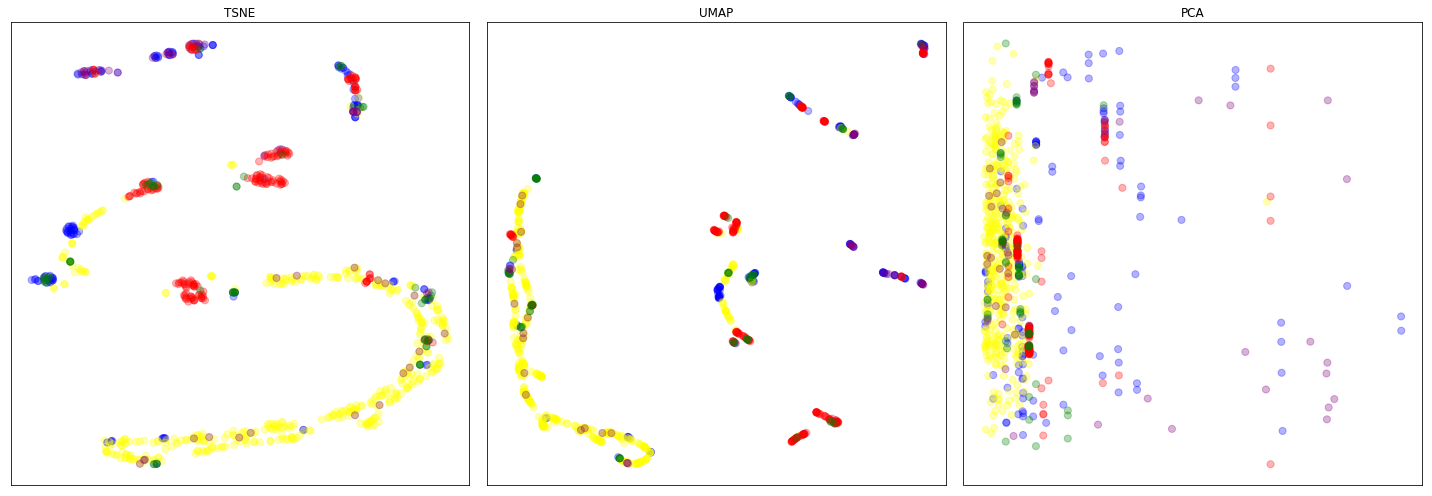

In [5]:
visualize_embedding(X, y)

These visualizations suggest that we should be able to guess the group field from the TLE data (at least better than random).

# Classification

### Import Libraries

- __keras__: deep learning library for Python (wraps tensorflow and others)
- __sklearn__ : classical machine learning techniques + some nice utilities

### Step 1: Split Data in Train and Test Sets

In [6]:
# Reserve 20% of the data for testing
# Startify the data split so that the train and test sets have the same class distribution

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

print('Generated train and test sets with the following sizes.')
print('Train X (features) {}, y (targets) {}'.format(X_train.shape, y_train.shape))
print('Test  X (features) {}, y (targets) {}'.format(X_test.shape, y_test.shape))
np.set_printoptions(suppress=True)

print()
print('Example Train Feature (X) and Target (y)')
print('  Feature {}'.format(', '.join(map(str,X[0]))))
print('  Target  {}'.format(y_train[0]))

Generated train and test sets with the following sizes.
Train X (features) (712, 9), y (targets) (712,)
Test  X (features) (179, 9), y (targets) (179,)

Example Train Feature (X) and Target (y)
  Feature 142.3965, 3.3869e-05, 0.0010458, 98.6875, 217.7946, 14.22130621, 3.1e-07, 78718.0, 253.009
  Target  2


### Step 2: Choose a metric

This will be our official measure of how well a given model has done at solving our problem.

In [7]:
metric = 'accuracy'

### Step 3: Choose a model

In [8]:
# Since we may rerun this cell many times, clearning the session helps to keep the
# layer names under control.
K.clear_session()

nb_classes = len(groups)

model = Sequential()
model.add(Dense(units=100, activation='relu', batch_input_shape=(16,9)))
model.add(Dense(units=100, activation='relu', name='penultimate'))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
# model.predict(np.zeros((16,9)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (16, 100)                 1000      
_________________________________________________________________
penultimate (Dense)          (16, 100)                 10100     
_________________________________________________________________
dense_2 (Dense)              (16, 5)                   505       
Total params: 11,605
Trainable params: 11,605
Non-trainable params: 0
_________________________________________________________________


### Training Step

In [9]:
repeats = 500
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.

def normalize(X):
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

model.fit(
    normalize(X_train.repeat(repeats, axis=0)),
    y_train.repeat(repeats, axis=0),
    validation_data=(normalize(X_test), y_test),
    epochs=100,
    batch_size=16,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss')],
    verbose=1
)

Train on 356000 samples, validate on 179 samples
Epoch 1/100
356000/356000 [==============================] - 18s 51us/step - loss: 0.9442 - acc: 0.6333 - val_loss: 0.6886 - val_acc: 0.7263
Epoch 2/100
356000/356000 [==============================] - 19s 54us/step - loss: 0.7326 - acc: 0.7167 - val_loss: 0.6009 - val_acc: 0.8045
Epoch 3/100
356000/356000 [==============================] - 17s 48us/step - loss: 0.6499 - acc: 0.7523 - val_loss: 0.5720 - val_acc: 0.7877
Epoch 4/100
356000/356000 [==============================] - 22s 61us/step - loss: 0.5996 - acc: 0.7703 - val_loss: 0.5236 - val_acc: 0.7989
Epoch 5/100
356000/356000 [==============================] - 15s 41us/step - loss: 0.5554 - acc: 0.7852 - val_loss: 0.7096 - val_acc: 0.7095
Epoch 6/100
356000/356000 [==============================] - 13s 37us/step - loss: 0.5121 - acc: 0.8000 - val_loss: 0.6545 - val_acc: 0.7877
Epoch 7/100
356000/356000 [==============================] - 14s 38us/step - loss: 0.4746 - acc: 0.8173 -

### Evaluate Trained Model on Test Data

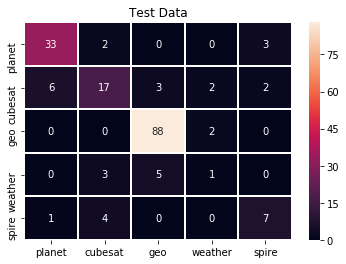

In [11]:
plot_confusion_matrix(X_test, y_test, 'Test Data', names=groups)

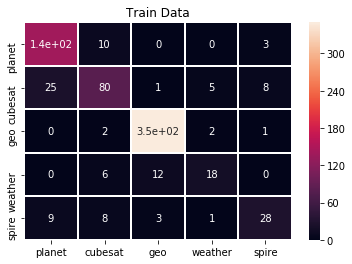

In [12]:
plot_confusion_matrix(X_train, y_train, 'Train Data', names=groups)

### Visualize Intermediate Layers -- Compare To Original Embeddings

You can think about the initial layers of a neural network as mapping your features into a space in which the decision problem is made easier for the terminal layers. By viewing the activations at various stages of the network, we can get a feel for how the data is being transformed. 

In [13]:
# Here we extract the intermediate features/activations from the layer named penultimate
layer_name = 'penultimate'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
X_penultimate_test = intermediate_layer_model.predict(normalize(X_test))

### Original Features

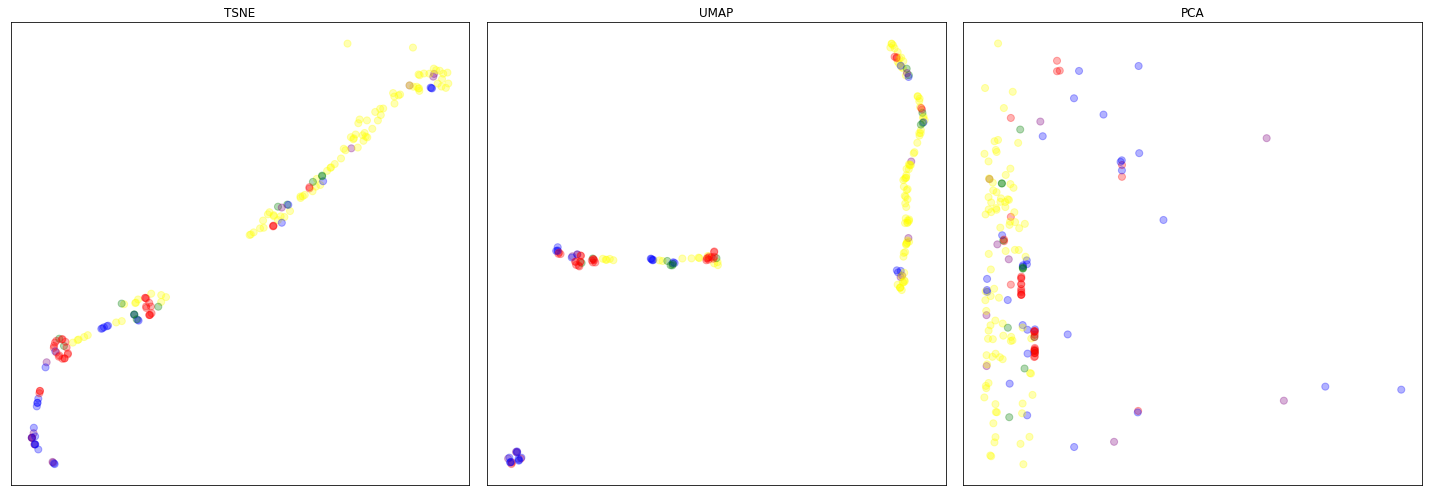

In [14]:
visualize_embedding(X_test, y_test)

### Learned Penultimate Features

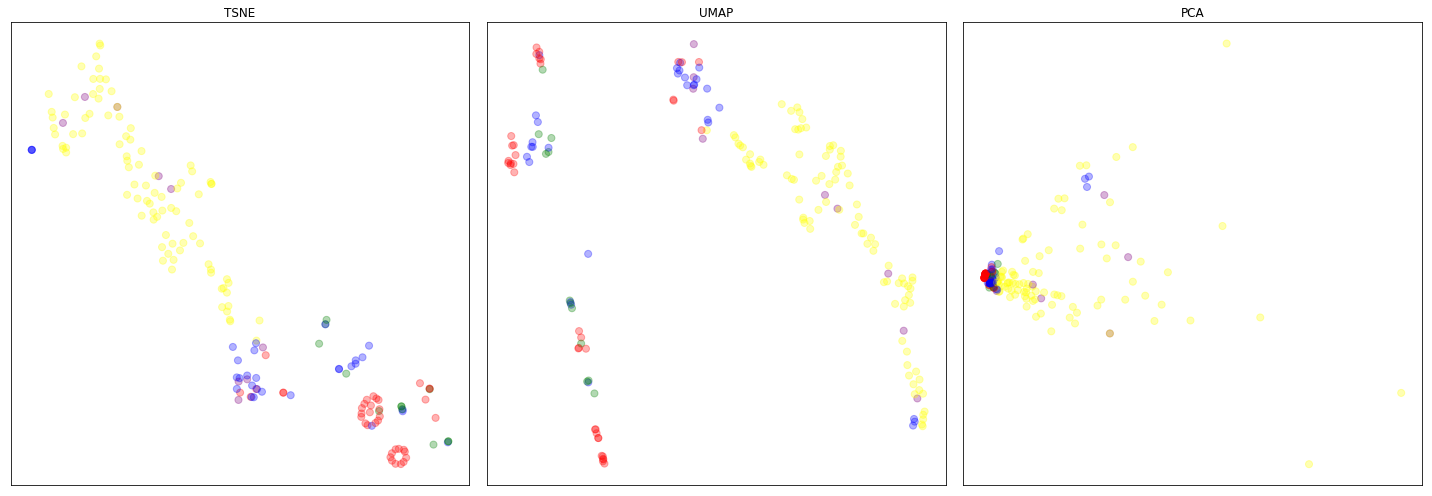

In [15]:
visualize_embedding(X_penultimate_test, y_test)

# Hyper-Parameter Search

To get a model working on your data, you probably made somewhat arbitrary choices of hyper-parmeters (e.g. type of model, number of layers, learning rate, regularization schemes, etc.). There's almost certainly an alternative choice of hyper-parmeters that would have resulted in a better model. It's tempting to use your model's performance on test data to decide which hyper-parameters should be kept and which should be changed.

However, once you start fiddling with hyper-parameters, your test metrics can no longer be trusted as estimates of your performance on new data. For this, you need a proper validation set. Where possible, you should avoid even looking at your validation dataset (except possibly to confirm that the train/test/validation sets seem to be drawn from the same distribution of data).

The most common approaches to hyper-parameter optimization are:
- __Grid Search__: Define a range of values for each hyper-parameter and test model with each combination of choices. This is usually must less efficient than random search because many hyper-parameter choices don't really matter.
- __Random Search__: Define a distribution for each hyper-parameter and test models sampled from these distributions. This is usually the best simple strategy.
- __Bayesian Hyper-Parameter Optimization__: This is generally considered state-of-the-art for black-box optimization but is much more complicated to implement yourself and there's not a lot of library support. This seems like an interesting service but I've never tried it: https://sigopt.com/ 

# Example Setup of Random Search

The following is a simple implementation of random search. 

In [16]:
def test_model(nb_layers=2, layer_width=100, dropout=True, regularizer=None, activation='relu', batch_size=16):

    # Build the Model
    nb_classes = len(groups)
    model = Sequential()
    for _ in range(nb_layers):
        dense_layer = Dense(
            units=layer_width,
            activation=activation,
            kernel_regularizer=regularizer,
            batch_input_shape=(batch_size,9)
        )
        model.add(dense_layer)
        if dropout:
            model.add(Dropout(0.5))
    model.add(Dense(units=nb_classes, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy']
    )

    # Train the Model
    repeats = 500
    early_stopping_patience = 3
    history = model.fit(
        normalize(X_train.repeat(repeats, axis=0)),
        y_train.repeat(repeats, axis=0),
        validation_data=(normalize(X_test), y_test),
        epochs=1000,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=early_stopping_patience, monitor='val_loss')],
        verbose=1
    )
    
    # Evaluate the Model
    # Training is setup to stop after val_loss failed to improve for <early_stopping_patience> many steps
    # So, we look back one more than that many steps to find the best score on our test data
    val_acc = history.history['val_acc'][-early_stopping_patience-1]
    
    return val_acc

In [17]:
# Define a space from which to draw random hyperparameters
def sample_config():
    return {
        'nb_layers': random.choice([1,2,3,4]),
        'layer_width': random.choice([10,50,100]),
        'dropout': random.choice([True, False]),
        'regularizer': random.choice([None, regularizers.l2(0.01), regularizers.l1(0.01)]),
        'activation': random.choice(['relu', 'linear', 'sigmoid']),
        'batch_size': random.choice([1,2,4,8,16,32,64])
    }    

# Generate some random sets of hyperparameters
nb_samples = 3
configs = [ sample_config() for _ in range(nb_samples) ]

for config in configs:
    print(config)
    score = test_model(**config)
    print('score = {}'.format(score))

{'nb_layers': 1, 'layer_width': 10, 'dropout': True, 'regularizer': None, 'activation': 'sigmoid', 'batch_size': 2}
Train on 356000 samples, validate on 179 samples
Epoch 1/1000
356000/356000 [==============================] - 92s 259us/step - loss: 1.2239 - acc: 0.5018 - val_loss: 1.1323 - val_acc: 0.5140
Epoch 2/1000
356000/356000 [==============================] - 91s 257us/step - loss: 1.1514 - acc: 0.5324 - val_loss: 1.0705 - val_acc: 0.6089
Epoch 3/1000
356000/356000 [==============================] - 89s 250us/step - loss: 1.1158 - acc: 0.5572 - val_loss: 1.0315 - val_acc: 0.6089
Epoch 4/1000
356000/356000 [==============================] - 82s 231us/step - loss: 1.0846 - acc: 0.5724 - val_loss: 0.9926 - val_acc: 0.6704
Epoch 5/1000
356000/356000 [==============================] - 82s 230us/step - loss: 1.0602 - acc: 0.5835 - val_loss: 0.9547 - val_acc: 0.6648
Epoch 6/1000
356000/356000 [==============================] - 84s 236us/step - loss: 1.0392 - acc: 0.5927 - val_loss: 0.